In [1]:
# %tensorflow_version 2.x

import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
train_dir='C:/Users/anupa/Downloads/Phase-1/Tongue/Train'
validation_dir='C:/Users/anupa/Downloads/Phase-1/Tongue/Val'
train_cancer=os.path.join(train_dir,'Cancer')
train_noncancer=os.path.join(train_dir,'Non Cancer')
val_cancer=os.path.join(validation_dir,'Cancer')
val_noncancer=os.path.join(validation_dir,'Non-Cancer')

In [3]:
train_c=os.listdir(train_cancer)
train_nc=os.listdir(train_noncancer)
val_c=os.listdir(val_cancer)
val_nc=os.listdir(val_noncancer)

print(len(train_c))
print(len(train_nc))
print(len(val_c))
print(len(val_nc))

95
185
31
63


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 280 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [5]:
def build_model():
  base_model = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

  model.summary()
  
  return model

In [6]:
model=build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='binary',
    target_size=(224,224)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=16,
    class_mode='binary',
    target_size=(224,224)
)

Found 280 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [10]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 40s 5s/step - loss: 37.7926 - accuracy: 0.4531 - val_loss: 0.6474 - val_accuracy: 0.7188
Epoch 2/20
4/4 [==============================] - 4s 980ms/step - loss: 0.6860 - accuracy: 0.6719 - val_loss: 0.7413 - val_accuracy: 0.2500
Epoch 3/20
4/4 [==============================] - 20s 6s/step - loss: 0.5888 - accuracy: 0.6750 - val_loss: 0.5262 - val_accuracy: 0.9531
Epoch 4/20
4/4 [==============================] - 4s 979ms/step - loss: 0.5843 - accuracy: 0.7750 - val_loss: 0.5235 - val_accuracy: 0.8750
Epoch 5/20
4/4 [==============================] - 4s 975ms/step - loss: 0.4171 - accuracy: 0.8750 - val_loss: 0.3892 - val_accuracy: 0.8906
Epoch 6/20
4/4 [==============================] - 4s 999ms/step - loss: 0.5225 - accuracy: 0.7188 - val_loss: 0.4308 - val_accuracy: 0.8125
Epoch 7/20
4/4 [==============================] - 4s 972ms/step - loss: 0.1322 - accuracy: 0.9583 - val_loss: 0.7561 - val_accuracy: 0.7188
Epoch 8/20
4/4 [=======

In [11]:
outputs = [layer.output for layer in model.layers[1:18]]
vis_model = Model(model.input, outputs)
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])
    print("Layers that will be used for visualization: ")
    print(layer_names)

Layers that will be used for visualization: 
['block1_conv1']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2']
Layers that will be used for visualization: 
['block1_conv1', 'bl

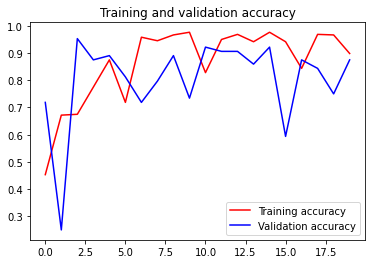

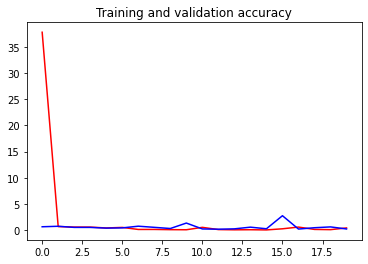

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')

plt.show()

In [13]:
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        tape.watch(conv_output_values)
        pred_prob = predictions[:,1] 
        
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        smoothing = 0.00001 
        
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()

    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [14]:
def show_sample(idx=None):
    
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]

    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

In [15]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
import scipy as sp
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/3,224/3, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'cancer' if round(results[0][0]) else 'non cancer'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [17]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (224,224)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)


sigmoid output: [[9.4747363e-04 9.9905246e-01]]
prediction: non cancer


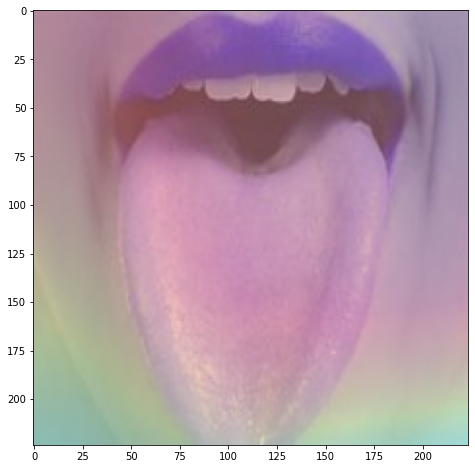

sigmoid output: [[6.424149e-07 9.999994e-01]]
prediction: non cancer


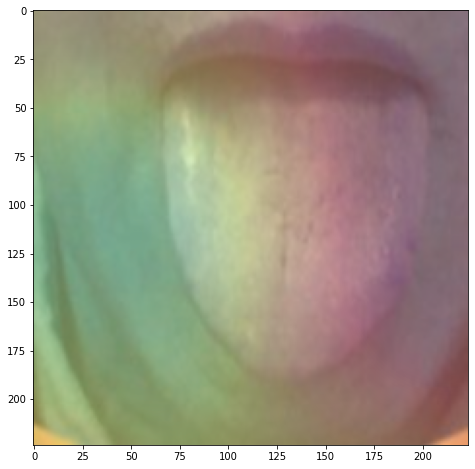

sigmoid output: [[1.0446838e-12 1.0000000e+00]]
prediction: non cancer


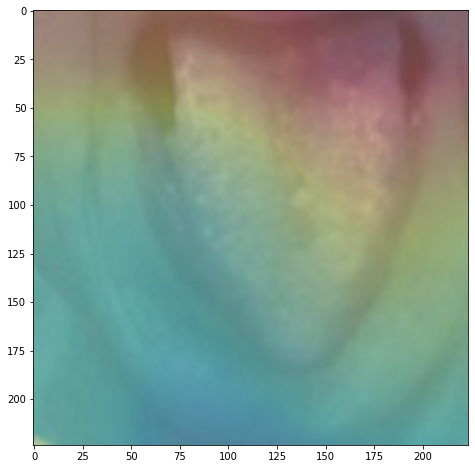

sigmoid output: [[8.704104e-09 1.000000e+00]]
prediction: non cancer


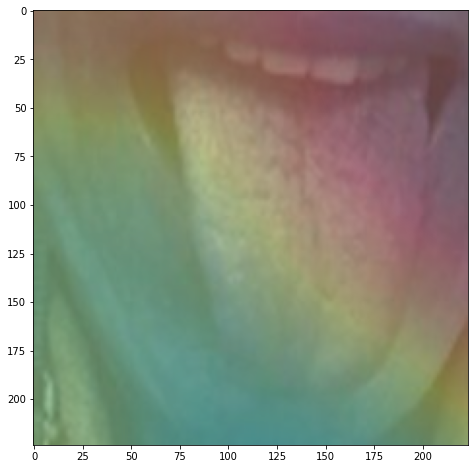

sigmoid output: [[0.01513957 0.9848605 ]]
prediction: non cancer


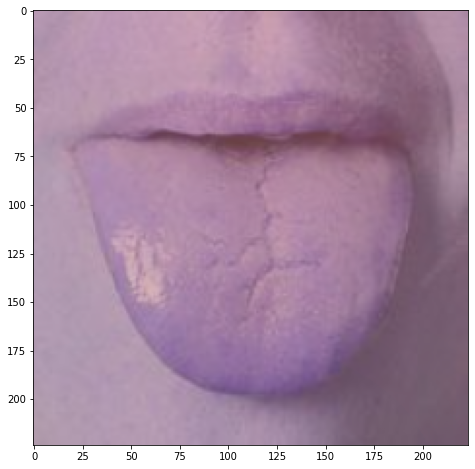

sigmoid output: [[1.4058717e-06 9.9999857e-01]]
prediction: non cancer


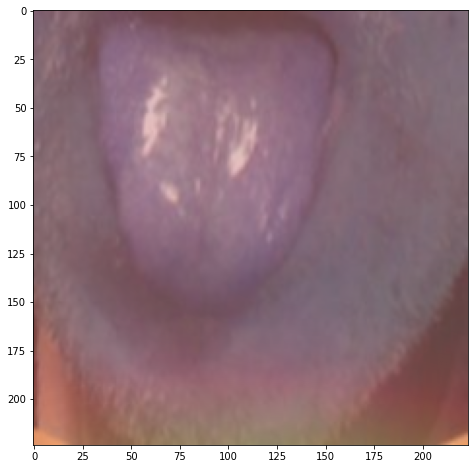

In [21]:
convert_and_classify('C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc64.jpg')
convert_and_classify('C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc120.jpg')
convert_and_classify('C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc85.jpg')
convert_and_classify('C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc109.jpg')
convert_and_classify('C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc48.jpg')
convert_and_classify('C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc88.jpg')

sigmoid output: [[3.5490433e-04 9.9964511e-01]]
prediction: non cancer


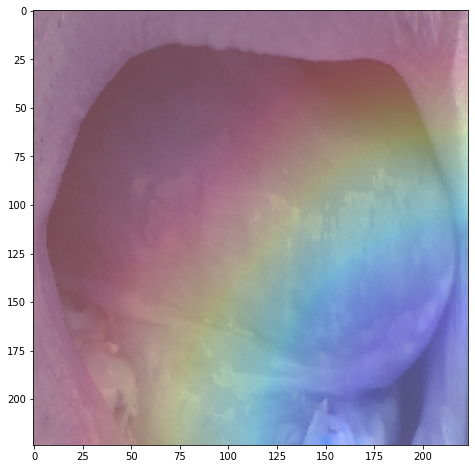

sigmoid output: [[1.0822678e-13 1.0000000e+00]]
prediction: non cancer


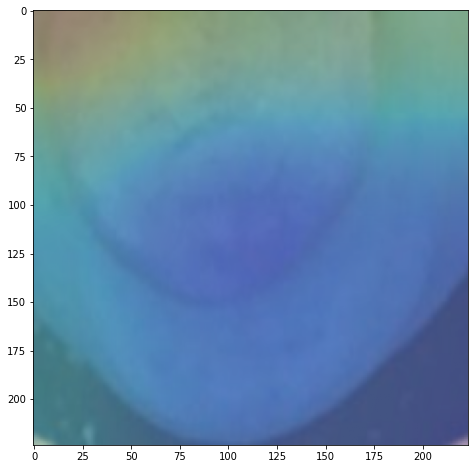

sigmoid output: [[2.4550702e-11 1.0000000e+00]]
prediction: non cancer


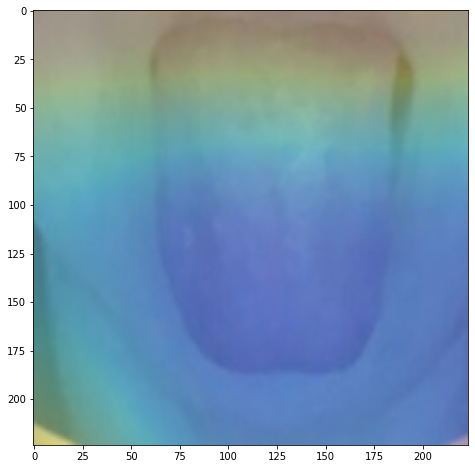

sigmoid output: [[3.8047045e-05 9.9996197e-01]]
prediction: non cancer


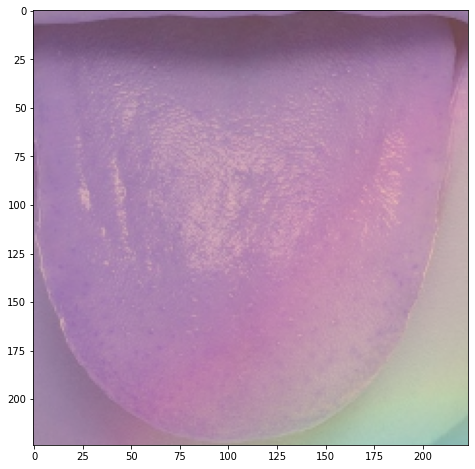

sigmoid output: [[4.0492457e-12 1.0000000e+00]]
prediction: non cancer


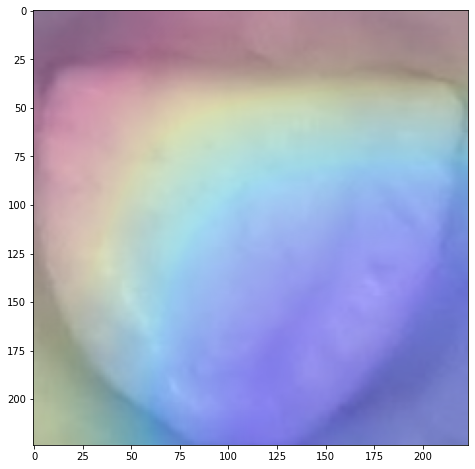

sigmoid output: [[7.9651e-11 1.0000e+00]]
prediction: non cancer


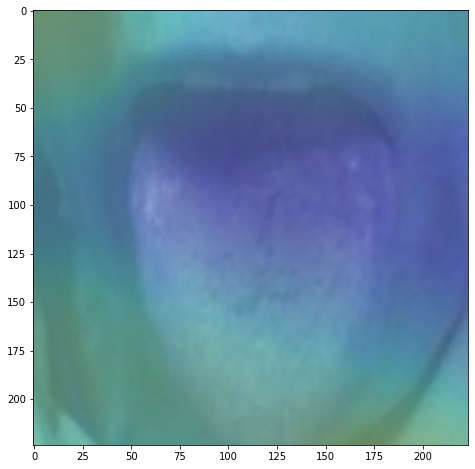

sigmoid output: [[3.3744405e-13 1.0000000e+00]]
prediction: non cancer


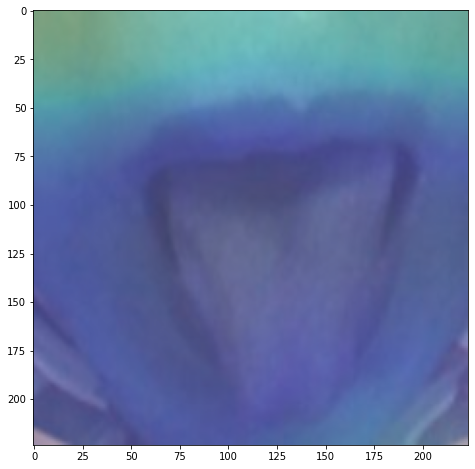

sigmoid output: [[4.233484e-12 1.000000e+00]]
prediction: non cancer


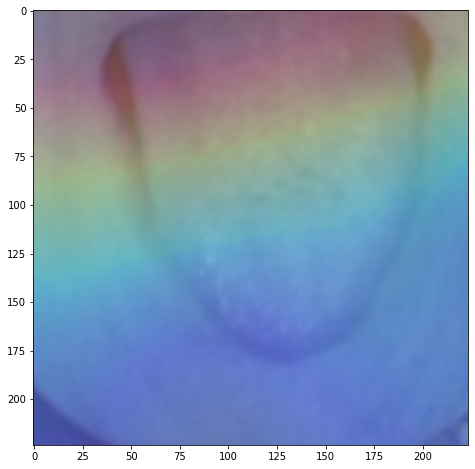

sigmoid output: [[6.896631e-17 1.000000e+00]]
prediction: non cancer


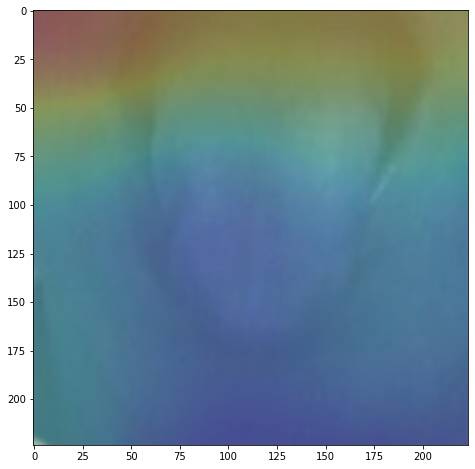

sigmoid output: [[4.879095e-07 9.999995e-01]]
prediction: non cancer


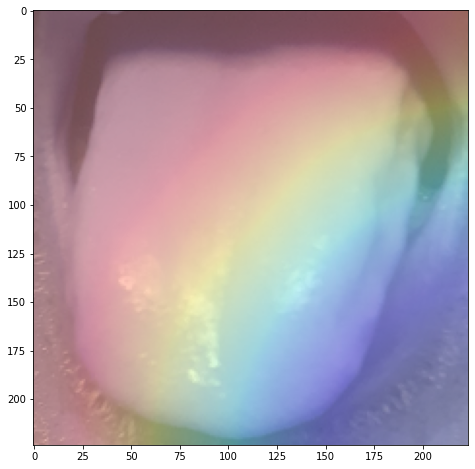

sigmoid output: [[3.804038e-08 1.000000e+00]]
prediction: non cancer


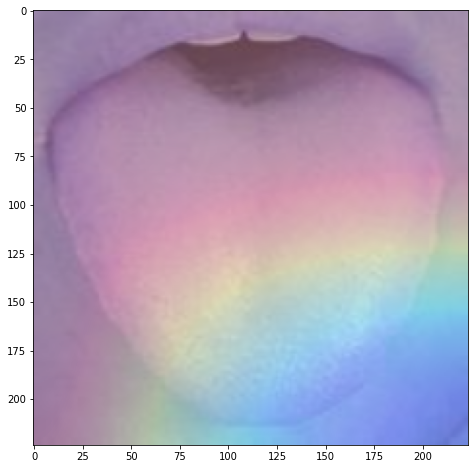

sigmoid output: [[2.3477881e-15 1.0000000e+00]]
prediction: non cancer


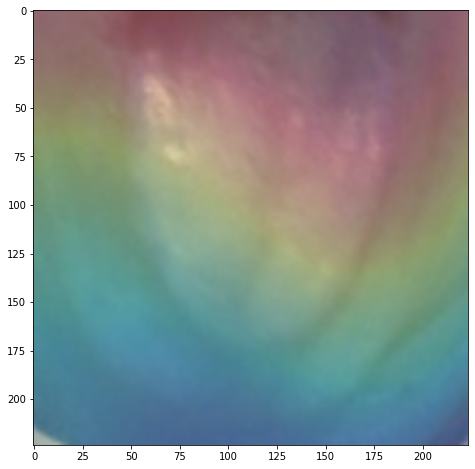

In [22]:
arr=['C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc10.jpg',
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc138.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc166.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc38.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc66.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc94.jpg',
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc110.jpg',     
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc139.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc167.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc39.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc67.jpg',   
     'C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc95.jpg']
for i in arr:
  convert_and_classify(i)


sigmoid output: [[0.89659077 0.10340922]]
prediction: cancer


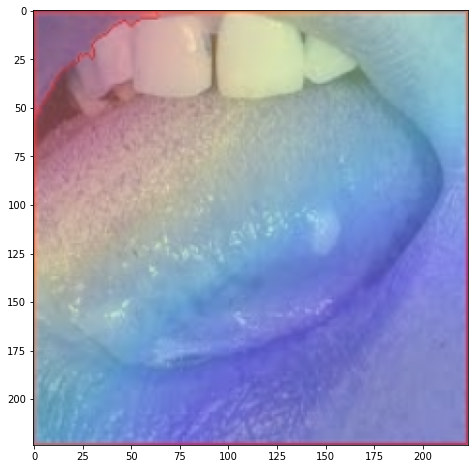

sigmoid output: [[0.9021786  0.09782146]]
prediction: cancer


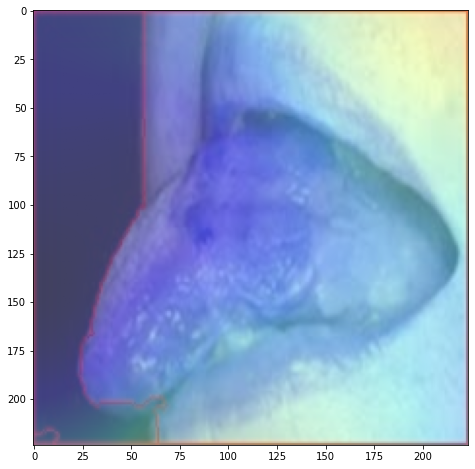

sigmoid output: [[0.6514001  0.34859985]]
prediction: cancer


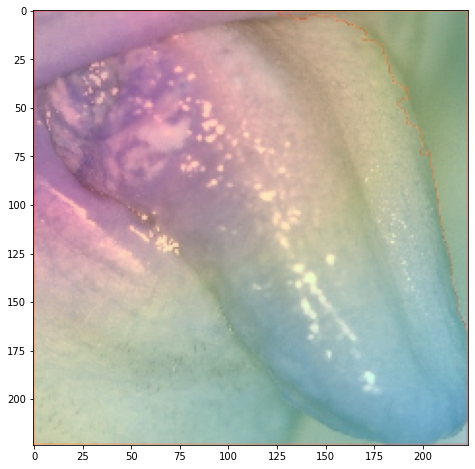

sigmoid output: [[0.98245484 0.01754514]]
prediction: cancer


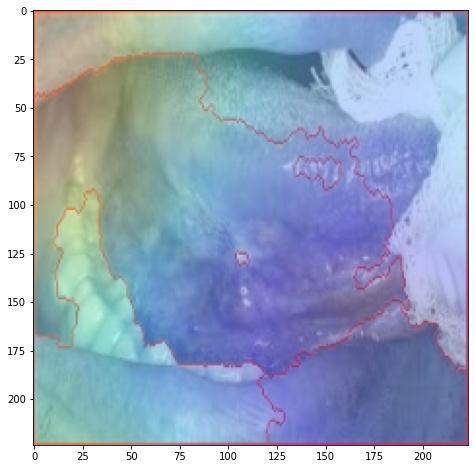

sigmoid output: [[0.678721   0.32127902]]
prediction: cancer


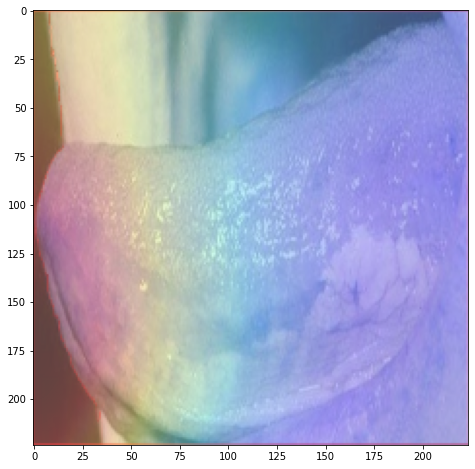

sigmoid output: [[0.9211559  0.07884401]]
prediction: cancer


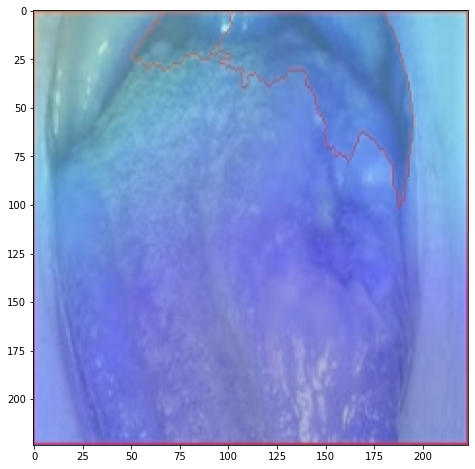

In [65]:
convert_and_classify('Good evening sir,
As you told us that you will recommend thia minor in IAM 2022. Can we get some insights on what the date can be for the same, and how much of the work must we do till iam.nc64.jpg')
convert_and_classify('nc120.jpg')
convert_and_classify('nc85.jpg')
convert_and_classify('nc109.jpg')
convert_and_classify('nc48.jpg')
convert_and_classify('nc88.jpg')

sigmoid output: [[0.950972   0.04902801]]
prediction: cancer


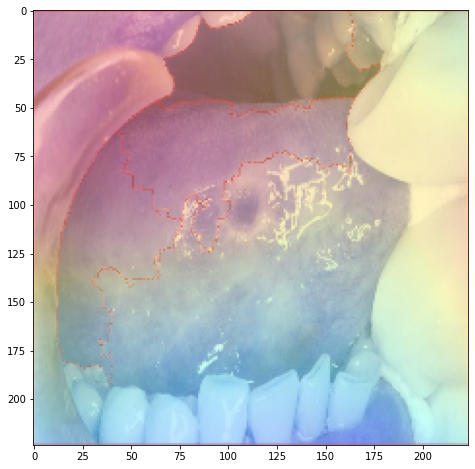

sigmoid output: [[0.6915404  0.30845955]]
prediction: cancer


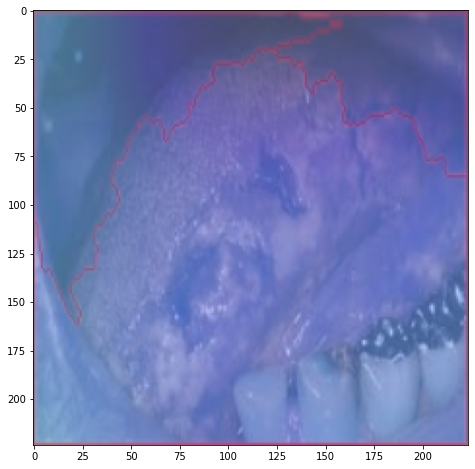

sigmoid output: [[0.939374   0.06062594]]
prediction: cancer


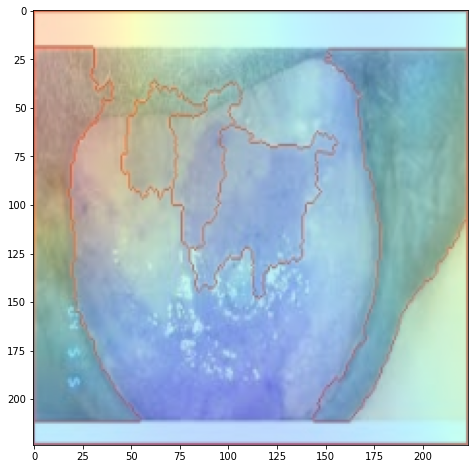

sigmoid output: [[0.99834013 0.00165981]]
prediction: cancer


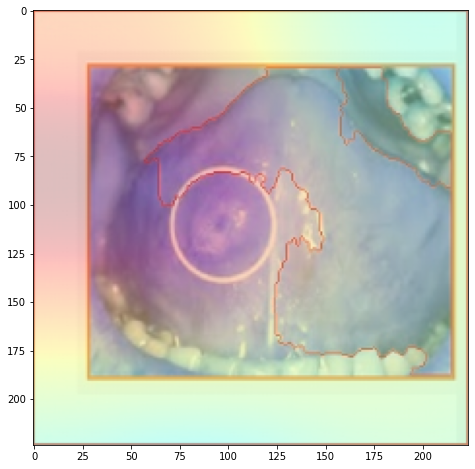

sigmoid output: [[0.73012525 0.26987478]]
prediction: cancer


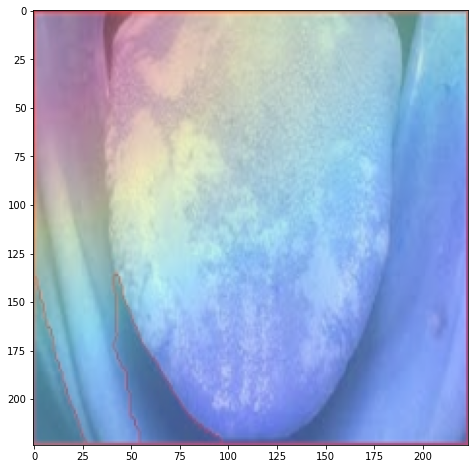

sigmoid output: [[0.8978578  0.10214219]]
prediction: cancer


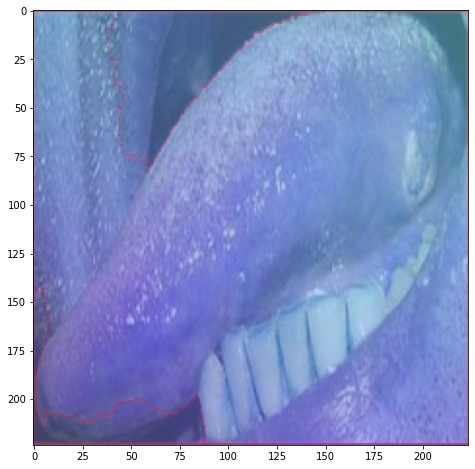

sigmoid output: [[0.4254953 0.5745047]]
prediction: non cancer


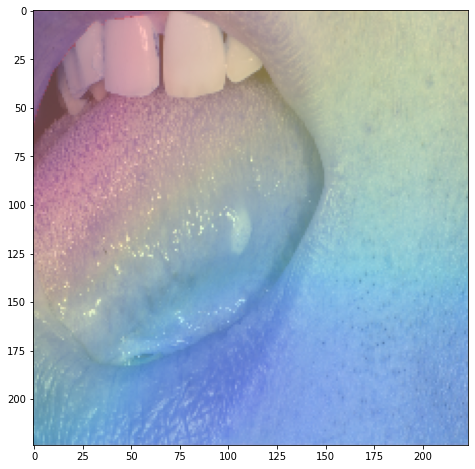

sigmoid output: [[0.96223027 0.03776977]]
prediction: cancer


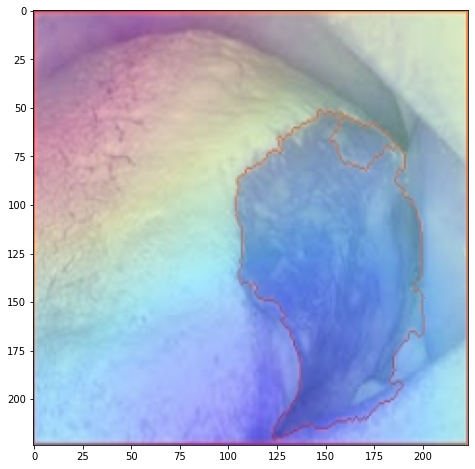

sigmoid output: [[0.94879156 0.05120837]]
prediction: cancer


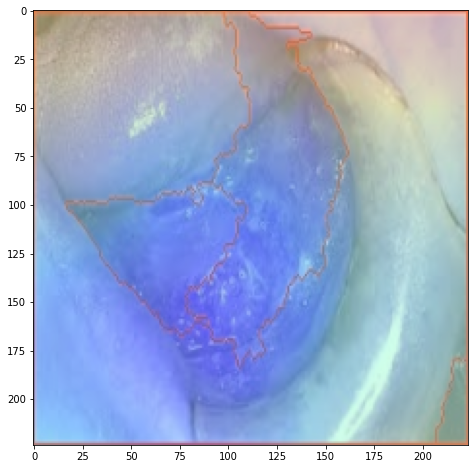

error: ignored

In [68]:
arr=['nc19.jpg',  'nc22.jpg',  'nc26.jpg',  'nc2.jpg',   'nc4.jpg',  'nc8.jpg',
'nc12.jpg',  'nc16.jpg',  'nc1.jpg',   'nc23.jpg'  'nc27.jpg',  'nc30.jpg']
for i in arr:
  convert_and_classify(i)

In [69]:
cd /content/drive/MyDrive/OralCancer/Final/Phase 1/Tongue/Val/Non-Cancer

/content/drive/MyDrive/OralCancer/Final/Phase 1/Tongue/Val/Non-Cancer


In [70]:
ls

'a_(10).jpg'   'a_(21).jpg'  'a_(33).jpg'  'a_(45).jpg'  'a_(57).jpg'
'a_(11).jpg'   'a_(22).jpg'  'a_(34).jpg'  'a_(46).jpg'  'a_(58).jpg'
'a_(12).jpg'   'a_(23).jpg'  'a_(35).jpg'  'a_(47).jpg'  'a_(59).jpg'
'a_(13).jpg'   'a_(24).jpg'  'a_(36).jpg'  'a_(48).jpg'  'a_(5).jpg'
'a_(14).jpg'   'a_(25).jpg'  'a_(37).jpg'  'a_(49).jpg'  'a_(60).jpg'
'a_(15).jpg'   'a_(26).jpg'  'a_(38).jpg'  'a_(4).jpg'   'a_(61).jpg'
'a_(16).jpg'   'a_(27).jpg'  'a_(39).jpg'  'a_(50).jpg'  'a_(62).jpg'
'a_(17).jpg'   'a_(28).jpg'  'a_(3).jpg'   'a_(51).jpg'  'a_(6).jpg'
'a_(18).jpg'   'a_(29).jpg'  'a_(40).jpg'  'a_(52).jpg'  'a_(7).jpg'
'a_(19).jpeg'  'a_(2).jpg'   'a_(41).jpg'  'a_(53).jpg'  'a_(8).jpg'
'a_(19).jpg'   'a_(30).jpg'  'a_(42).jpg'  'a_(54).jpg'  'a_(9).jpg'
'a_(1).jpg'    'a_(31).jpg'  'a_(43).jpg'  'a_(55).jpg'
'a_(20).jpg'   'a_(32).jpg'  'a_(44).jpg'  'a_(56).jpg'


sigmoid output: [[0.68647146 0.31352854]]
prediction: cancer


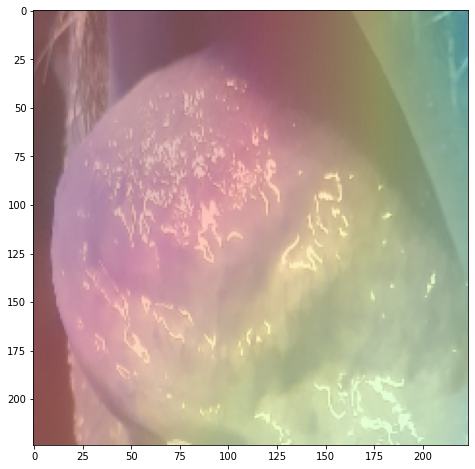

sigmoid output: [[3.5493438e-06 9.9999642e-01]]
prediction: non cancer


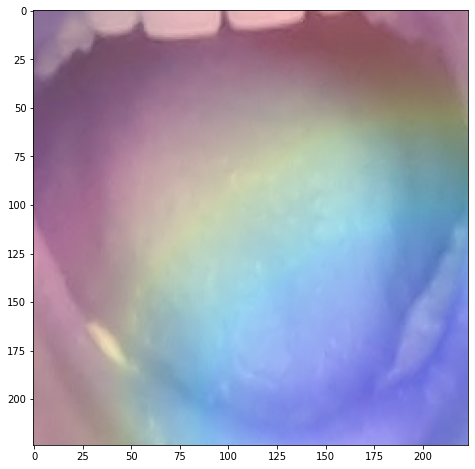

sigmoid output: [[0.37058324 0.6294168 ]]
prediction: non cancer


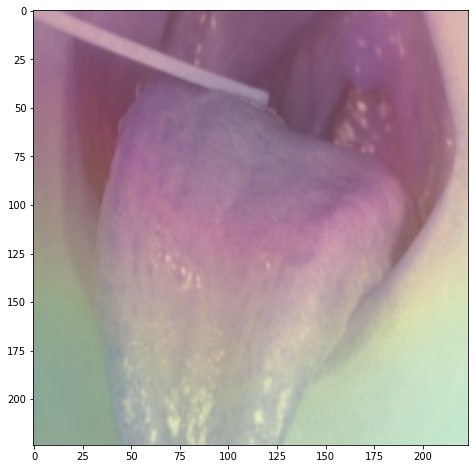

sigmoid output: [[0.00259437 0.9974056 ]]
prediction: non cancer


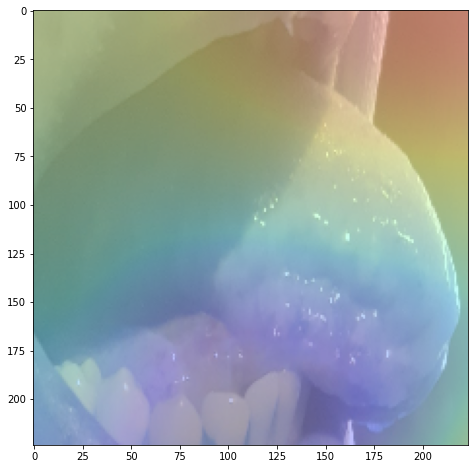

error: ignored

In [71]:
arr=['a_(19).jpeg',  'a_(2).jpg',   'a_(41).jpg' , 'a_(53).jpg',  'a_(8).jpg'
'a_(19).jpg',   'a_(30).jpg' , 'a_(42).jpg',  'a_(54).jpg']
for i in arr:
  convert_and_classify(i)